In [66]:
"""
see if ABA is low-dimesional as is indicated by cross-dataset CFS (and lasso to a lesser degree) results

Modified from: allenadultmouseISH/lowdim_twentyseven.ipynb; data filt funcs from 09_crossdataset.ipynb

Shaina Lu
Zador & Gillis Labs
June 2020
"""

'\nsee if ABA is low-dimesional as is indicated by cross-dataset CFS (and lasso to a lesser degree) results\n\nModified from: allenadultmouseISH/lowdim_twentyseven.ipynb; data filt funcs from 09_crossdataset.ipynb\n\nShaina Lu\nZador & Gillis Labs\nJune 2020\n'

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.decomposition import PCA
#import random
from mpl_toolkits.mplot3d import Axes3D    #used for 3D scatterplots
import seaborn as sns

In [68]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in and filter Data
Use functions from 09_crossdataset.ipynb

In [69]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

In [70]:
#ABA
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

All pre-processing functions from script

In [71]:
def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

In [72]:
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
STmeta, STspots, STpropont = read_STdata()

#filter brain areas for those that have at least x samples
STpropont = filterproponto(STpropont)
ABApropont = filterproponto(ABApropont)
#filter brain areas for overlapping leaf areas
STpropont, ABApropont = findoverlapareas(STpropont, ABApropont, ontology)

#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

number of leaf areas: 461
number of leaf areas: 560
number of overlapping genes: 14299


# PCA Dimensionality Reduction
Look at number of PCs to capture ~80% of variance relative total number of samples across brain areas

In [73]:
def runPCA(numcomponents,data):
    #fit PCA and transform on whole dataset
    pcamod = PCA(n_components = numcomponents)
    pcamod.fit(data)
    XlowD = pcamod.transform(data)
    XlowD = pd.DataFrame(XlowD)
    return pcamod, XlowD

Plots of all brain areas

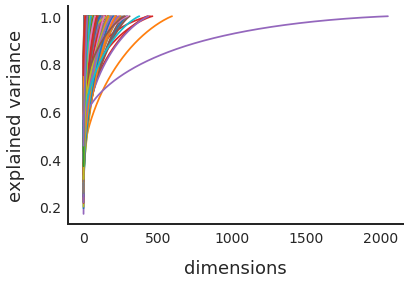

In [11]:
#set up code to look at all brain areas
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    #if currarea == '672': #skip caudoputamen
    #    continue
    #subset ABA and ST data for current area
    currST = STspots.loc[STpropont[currarea] == 1, :]
    #currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #fit PCA for given number of samples
    currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST)
    #currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA)
    #variance explained
    STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    #ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    #plots
    plt.xlabel("dimensions")
    plt.ylabel("explained variance")
    plt.plot(STcumsum)
plt.savefig("062620_5.pdf", bbox_inches='tight')

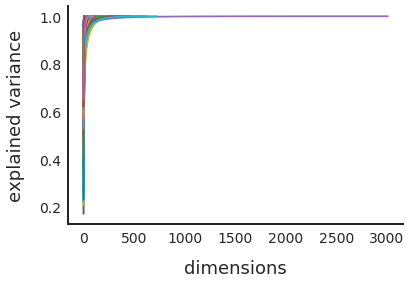

In [12]:
#set up code to look at all brain areas
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    #if currarea == '672': #skip caudoputamen
    #    continue
    #subset ABA and ST data for current area
    #currST = STspots.loc[STpropont[currarea] == 1, :]
    currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #fit PCA for given number of samples
    #currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST)
    currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA)
    #variance explained
    #STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    #plots
    plt.xlabel("dimensions")
    plt.ylabel("explained variance")
    plt.plot(ABAcumsum)
plt.savefig("062620_6.pdf", bbox_inches='tight')

Sample plot of one brain area

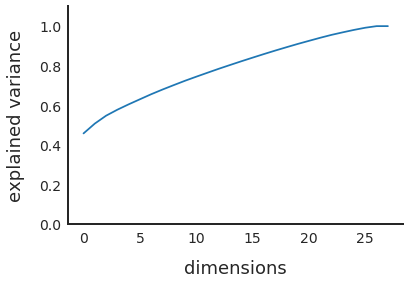

In [13]:
cumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
plt.plot(cumsum)
#plt.bar(range(500),pca500.explained_variance_ratio_)
plt.ylabel("explained variance")
plt.xlabel("dimensions")
plt.ylim(0,1.1)
#plt.savefig("020819_2.pdf", bbox_inches='tight')
plt.show()

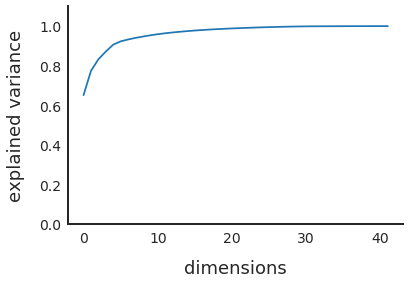

In [14]:
cumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
plt.plot(cumsum)
#plt.bar(range(500),pca500.explained_variance_ratio_)
plt.ylabel("explained variance")
plt.xlabel("dimensions")
plt.ylim(0,1.1)
#plt.savefig("020819_2.pdf", bbox_inches='tight')
plt.show()

Now, quantify number of dimensions per brain area compared to total samples

In [8]:
STvarexp = []
ABAvarexp = []
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    #subset ABA and ST data for current area
    currST = STspots.loc[STpropont[currarea] == 1, :]
    currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #fit PCA for given number of samples
    currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST)
    currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA)
    #variance explained
    STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    STvarexp.append(STcumsum)
    ABAvarexp.append(ABAcumsum)

In [16]:
#ST
STnumcomps = []
STnumsamps = []
for i in range(len(STvarexp)):
    STnumsamps.append(len(STvarexp[i]))
    for j in range(len(STvarexp[i])):
        if STvarexp[i][j] >= 0.8:
            STnumcomps.append(j)
            break

In [17]:
#ABA
ABAnumcomps = []
ABAnumsamps = []
for i in range(len(ABAvarexp)):
    ABAnumsamps.append(len(ABAvarexp[i]))
    for j in range(len(ABAvarexp[i])):
        if ABAvarexp[i][j] >= 0.8:
            ABAnumcomps.append(j)
            break

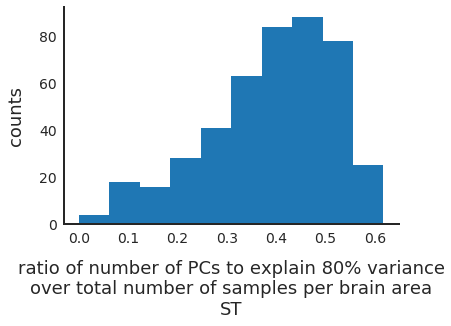

In [18]:
plt.hist(np.array(STnumcomps)/np.array(STnumsamps))
plt.xlabel("ratio of number of PCs to explain 80% variance\nover total number of samples per brain area\nST")
plt.ylabel("counts")
#plt.savefig("033020_5.pdf", bbox_inches='tight')
plt.show()

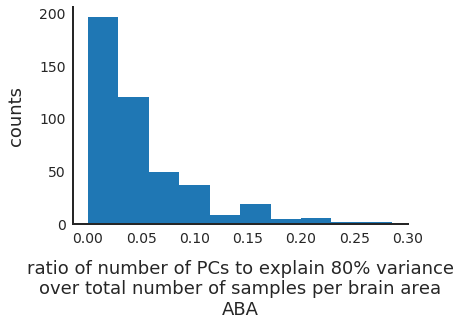

In [19]:
plt.hist(np.array(ABAnumcomps)/np.array(ABAnumsamps))
plt.xlabel("ratio of number of PCs to explain 80% variance\nover total number of samples per brain area\nABA")
plt.ylabel("counts")
#plt.savefig("033020_6.pdf", bbox_inches='tight')
plt.show()

try subsamplig ABA to have the same number of areas as ST; this is PCA of genes

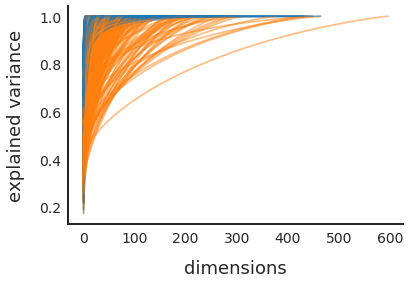

In [74]:
#set up code to look at all brain areas
ABAsmallerST = []
ABAsubvarexp = []
STvarexp = []
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    if currarea == '672': #skip caudoputamen
        continue
    #subset ABA and ST data for current area
    currST = STspots.loc[STpropont[currarea] == 1, :]
    currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #subsample ABA to be the same size as ST for a given brain area
    if currABA.shape[0] >= currST.shape[0]:
        subsamp = np.random.choice(currABA.index, size=currST.shape[0], replace=False)
        currABA = currABA.loc[subsamp, :]
    else:
        ABAsmallerST.append(currname)
    #fit PCA for given number of samples
    currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST)
    currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA)
    #variance explained
    STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    STvarexp.append(STcumsum)
    ABAsubvarexp.append(ABAcumsum)
    #plots
    plt.plot(STcumsum, color='C1', alpha=0.5, label="ST")
    plt.plot(ABAcumsum, color='C0', alpha=0.5, label="ABA")

plt.xlabel("dimensions")
plt.ylabel("explained variance")
#plt.legend()
#plt.savefig("080520_6.pdf", bbox_inches='tight')
plt.show()

In [75]:
#areas that have fewer samples in ABA than ST
len(ABAsmallerST)

77

In [76]:
#ST
STnumcomps = []
STnumsamps = []
for i in range(len(STvarexp)):
    STnumsamps.append(len(STvarexp[i]))
    for j in range(len(STvarexp[i])):
        if STvarexp[i][j] >= 0.8:
            STnumcomps.append(j)
            break

In [77]:
#ABA sub samples
ABAnumcomps = []
ABAnumsamps = []
for i in range(len(ABAsubvarexp)):
    ABAnumsamps.append(len(ABAsubvarexp[i]))
    for j in range(len(ABAsubvarexp[i])):
        if ABAsubvarexp[i][j] >= 0.8:
            ABAnumcomps.append(j)
            break

In [82]:
#on average how many PC's to capture 80% variance?
print(np.average(STnumcomps))
print(np.average(ABAnumcomps))

21.04954954954955
2.2027027027027026


(-10, 400)

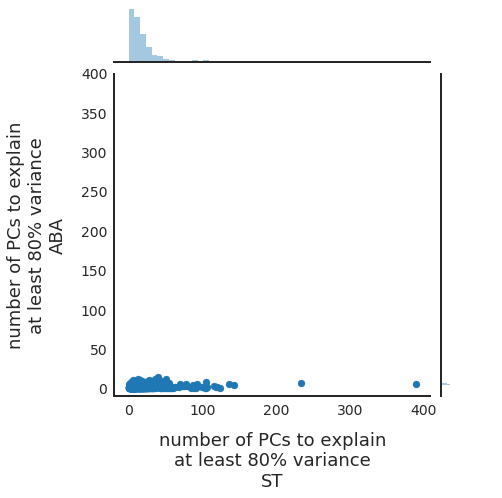

In [26]:
sns.jointplot(STnumcomps, ABAnumcomps).set_axis_labels("number of PCs to explain\nat least 80% variance\nST","number of PCs to explain\nat least 80% variance\nABA")
plt.ylim([-10,400])
#plt.savefig("062620_9.pdf", bbox_inches='tight')

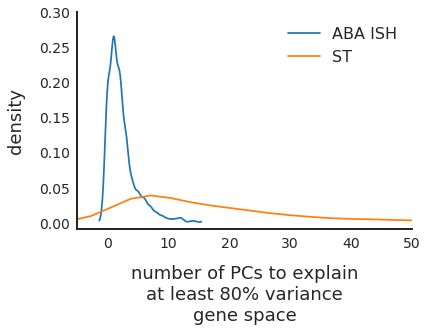

In [60]:
sns.kdeplot(ABAnumcomps, label="ABA ISH")
sns.kdeplot(STnumcomps, label="ST")
plt.legend()
plt.xlabel("number of PCs to explain\nat least 80% variance\ngene space")
plt.ylabel("density")
plt.ylim([-0.01, 0.3])
plt.xlim([-5,50])
plt.savefig("080520_5.pdf", bbox_inches='tight')
plt.show()

In [61]:
#MWU of the ST v. ABA
sp.stats.mannwhitneyu(ABAnumcomps, STnumcomps, alternative='two-sided')

MannwhitneyuResult(statistic=14135.0, pvalue=2.443360208931275e-109)

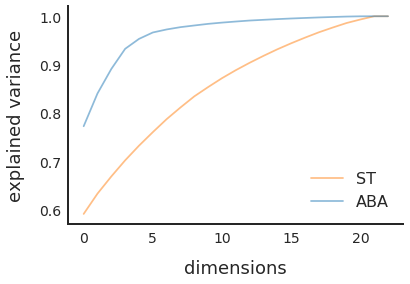

In [35]:
#plot curves of ST and sub-sampled ABA together
#set up code to look at all brain areas
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    if currarea == '672': #skip caudoputamen
        continue
    #subset ABA and ST data for current area
    currST = STspots.loc[STpropont[currarea] == 1, :]
    currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #subsample ABA to be the same size as ST for a given brain area
    if currABA.shape[0] >= currST.shape[0]:
        subsamp = np.random.choice(currABA.index, size=currST.shape[0], replace=False)
        currABA = currABA.loc[subsamp, :]
    #else:
    #    ABAsmallerST.append(currname)
    #fit PCA for given number of samples
    currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST)
    currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA)
    #variance explained
    STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    #plots
    plt.plot(STcumsum, color='C1', alpha=0.5, label="ST")
    plt.plot(ABAcumsum, color='C0', alpha=0.5, label="ABA")
    #break

plt.xlabel("dimensions")
plt.ylabel("explained variance")
#plt.legend()
#plt.savefig("062920_3.pdf", bbox_inches='tight')

PCA on sample space instead of genes as all above
still sub-sample ABA

In [9]:
#set up code to look at all brain areas
ABAsmallerST = []
ABAsubvarexp = []
STvarexp = []
areas = list(STpropont)
for i in range(len(areas)):
    currarea = areas[i]
    currname = ontology.loc[ontology.id == int(currarea), "acronym"]
    #if currarea == '672': #skip caudoputamen
    #    continue
    #subset ABA and ST data for current area
    currST = STspots.loc[STpropont[currarea] == 1, :]
    currABA = ABAvox.loc[ABApropont[currarea] == 1, :]
    #subsample ABA to be the same size as ST for a given brain area
    if currABA.shape[0] >= currST.shape[0]:
        subsamp = np.random.choice(currABA.index, size=currST.shape[0], replace=False)
        currABA = currABA.loc[subsamp, :]
    else:
        ABAsmallerST.append(currname)
    #fit PCA for given number of samples
    currSTPCAmod, currST_transform = runPCA(currST.shape[0], currST.T)
    currABAPCAmod, currABA_transform = runPCA(currABA.shape[0], currABA.T)
    #variance explained
    STcumsum = np.cumsum(currSTPCAmod.explained_variance_ratio_)
    ABAcumsum = np.cumsum(currABAPCAmod.explained_variance_ratio_)
    STvarexp.append(STcumsum)
    ABAsubvarexp.append(ABAcumsum)
    #plots
    #plt.xlabel("dimensions\nABA sub-sampled")
    #plt.ylabel("explained variance")
    #plt.ylim(0,1.1)
    #plt.plot(ABAcumsum)
    break
#plt.savefig("062620_7.pdf", bbox_inches='tight')

In [20]:
#areas that have fewer samples in ABA than ST
len(ABAsmallerST)

77

In [21]:
#ST
STnumcomps = []
STnumsamps = []
for i in range(len(STvarexp)):
    STnumsamps.append(len(STvarexp[i]))
    for j in range(len(STvarexp[i])):
        if STvarexp[i][j] >= 0.8:
            STnumcomps.append(j)
            break

In [22]:
#ABA sub samples
ABAnumcomps = []
ABAnumsamps = []
for i in range(len(ABAsubvarexp)):
    ABAnumsamps.append(len(ABAsubvarexp[i]))
    for j in range(len(ABAsubvarexp[i])):
        if ABAsubvarexp[i][j] >= 0.8:
            ABAnumcomps.append(j)
            break

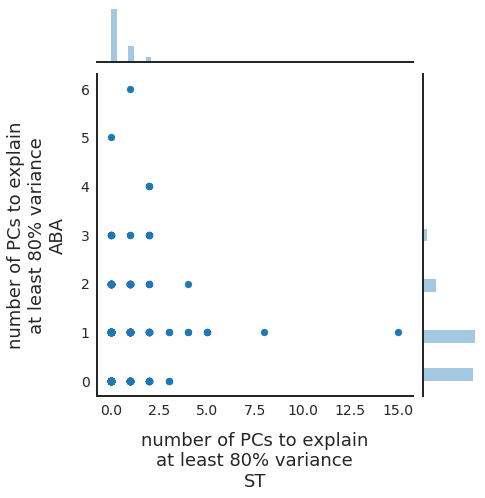

In [24]:
sns.jointplot(STnumcomps, ABAnumcomps).set_axis_labels("number of PCs to explain\nat least 80% variance\nST","number of PCs to explain\nat least 80% variance\nABA")
#plt.ylim([-10,400])
#plt.savefig("062620_9.pdf", bbox_inches='tight')

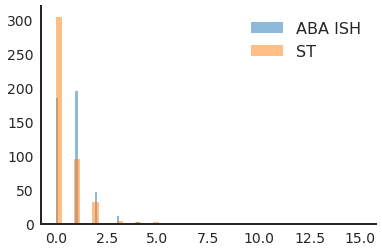

In [38]:
plt.hist(ABAnumcomps, bins=50, alpha=0.5, label="ABA ISH")
plt.hist(STnumcomps, bins=50, alpha=0.5, label="ST")
plt.legend()
plt.savefig("072820_2.pdf", bbox_inches='tight')
plt.show()